# Semantic Segmentation

In this tutorial we will fine tune a U-NET model for semantic segmentation on the [Oxford-IIIT Pet Dataset](https://www.robots.ox.ac.uk/~vgg/data/pets/).

In [1]:
import cv2
import os
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchsummary import summary

## Data Preparation

In [ ]:
# let's start by downloading the necessary data
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!curl -O https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  755M  100  755M    0     0  13.5M      0  0:00:55  0:00:55 --:--:-- 14.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.2M  100 18.2M    0     0  4764k      0  0:00:03  0:00:03 --:--:-- 4763k


In [2]:
# get train and validation datasets
images_directory = "data/pet_images/images"
masks_directory = os.path.join("data/pet_annotations", "trimaps")

images_filenames = list(sorted(os.listdir(images_directory)))
# filter out images that can not be loaded properly
correct_images_filenames = [i for i in images_filenames if cv2.imread(os.path.join(images_directory, i)) is not None]

random.seed(42)
random.shuffle(correct_images_filenames)

train_images_filenames = correct_images_filenames[:2000]
val_images_filenames = correct_images_filenames[2000:2500]

print(len(train_images_filenames), len(val_images_filenames))

Corrupt JPEG data: premature end of data segment
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


2000 500


In [3]:
# the dataset has 3 labels (1 - pet, 2 - background and 3 - border), so we convert it to a binary problem with (0 - background and 1 - pet/border)
def preprocess_mask(mask):
    mask = mask.astype(np.float32)
    mask[mask == 2.0] = 0.0
    mask[(mask == 1.0) | (mask == 3.0)] = 1.0
    return mask

In [4]:
# before proceeding, let us visualize some examples
def display_image_grid(images_filenames, images_directory, masks_directory):
    rows = len(images_filenames)
    figure, ax = plt.subplots(nrows=rows, ncols=2, figsize=(10, 24))
    for i, image_filename in enumerate(images_filenames):
        image = cv2.imread(os.path.join(images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(os.path.join(masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,)
        mask = preprocess_mask(mask)
        ax[i, 0].imshow(image)
        ax[i, 1].imshow(mask, interpolation="nearest", cmap='gray')

        ax[i, 0].set_title("Image")
        ax[i, 1].set_title("Ground truth mask")

        ax[i, 0].set_axis_off()
        ax[i, 1].set_axis_off()

    plt.tight_layout()
    plt.show()

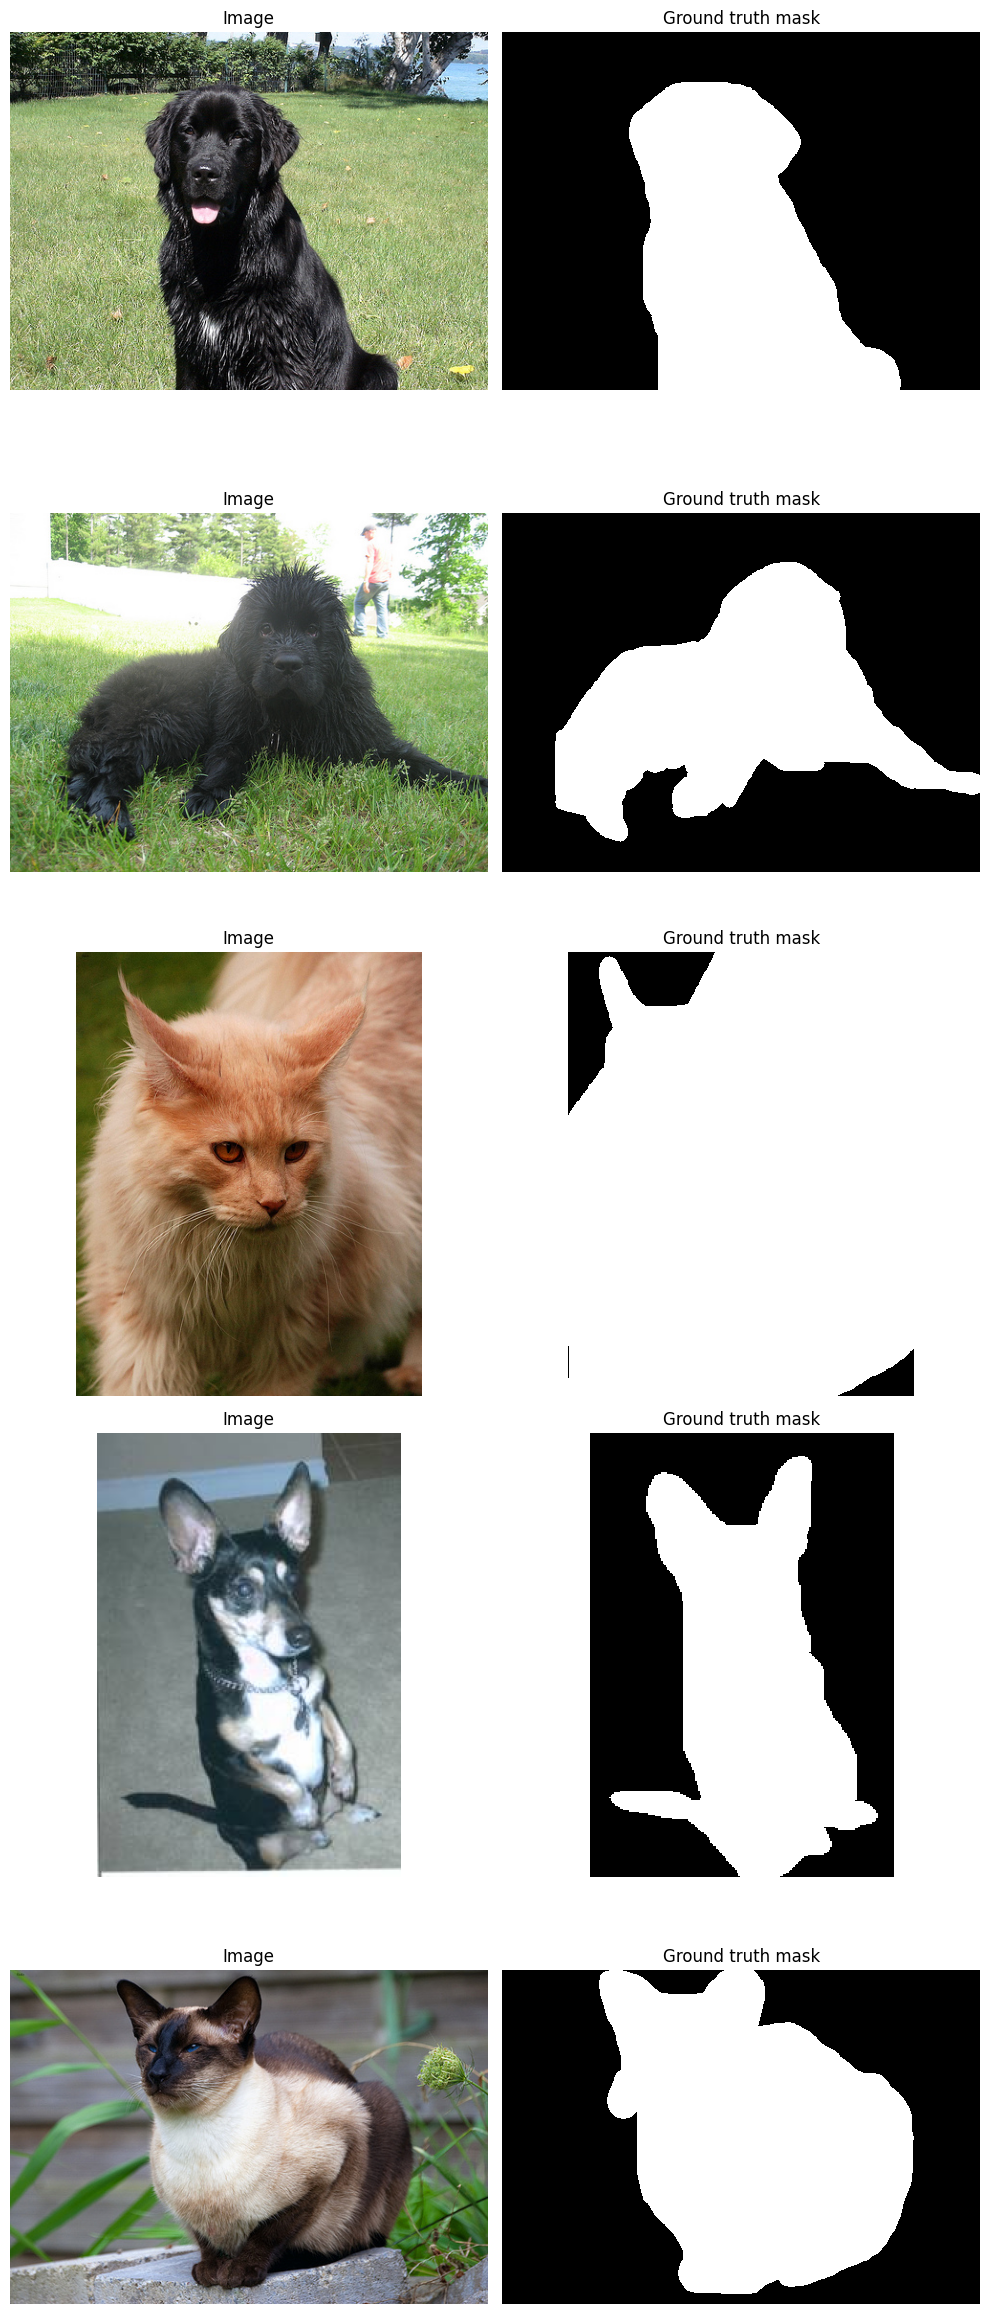

In [5]:
display_image_grid(train_images_filenames[:5], images_directory, masks_directory)

In [6]:
# let's define our dataset
class OxfordPetDataset(Dataset):
    def __init__(self, images_filenames, images_directory, masks_directory, transform=None):
        self.images_filenames = images_filenames
        self.images_directory = images_directory
        self.masks_directory = masks_directory
        self.transform = transform

    def __len__(self):
        return len(self.images_filenames)

    def __getitem__(self, idx):
        image_filename = self.images_filenames[idx]
        image = cv2.imread(os.path.join(self.images_directory, image_filename))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # transform image into 0-1 range
        # note that the ToTensorV2 method from the albumentations library does not automatically convert the image range into 0-1
        image = image / 255.

        mask = cv2.imread(
            os.path.join(self.masks_directory, image_filename.replace(".jpg", ".png")), cv2.IMREAD_UNCHANGED,
        )
        mask = preprocess_mask(mask)

        # when applying data augmentation we need to make sure both input image and target mask are augmented using exactly the same augmentation
        # this is straightforward using the albumentations library (https://github.com/albumentations-team/albumentations)
        if self.transform is not None:
            transformed = self.transform(image=image, mask=mask)
            image = transformed["image"]
            mask = transformed["mask"]
        return image.float(), mask.to(torch.int64)

In [7]:
# hyperparameters
nr_classes = 2 # background vs foreground/animal
batch_size = 8
num_workers = 4
epochs = 3
learning_rate = 1e-4

# device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
# define transforms and datasets
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.RandomCrop(224, 224),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        ToTensorV2(),
    ]
)
train_dataset = OxfordPetDataset(train_images_filenames, images_directory, masks_directory, transform=train_transform,)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

val_transform = A.Compose(
    [A.Resize(256, 256), A.CenterCrop(224, 224), ToTensorV2()]
)
val_dataset = OxfordPetDataset(val_images_filenames, images_directory, masks_directory, transform=val_transform,)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

## Model

In [9]:
# U-Net implementation from https://github.com/milesial/Pytorch-UNet

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class SegmentationNetwork(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(SegmentationNetwork, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

Analyse the implemented SegmentationNetwork. 

What type of architecture is being implemented? U-Net.

What is the shape of the output and embedding tensors? The shape of the output is the same of the input tensor. The shape of the embedding tensor is 1024x14x14 for an input of 3x224x224.

## Train the model

In [10]:
# create model
model = SegmentationNetwork(n_channels=3, n_classes=nr_classes)
print(model)

# put model in GPU
model.to(device)

# define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# define loss
loss_fn = torch.nn.CrossEntropyLoss()

# define metric (e.g. Jaccard Index, Dice Coefficient, Pixel Accuracy)
from torchmetrics import JaccardIndex
metric = JaccardIndex(num_classes=nr_classes, task='multiclass')

SegmentationNetwork(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)

In [11]:
# train the model (do not forget to save your best model during training)
def epoch_iter(dataloader, model, loss_fn, optimizer=None, is_train=True):
    if is_train:
      assert optimizer is not None, "When training, please provide an optimizer."
      
    num_batches = len(dataloader)

    if is_train:
      model.train() # put model in train mode
    else:
      model.eval()

    total_loss = 0.0
    total_jaccard = 0.0

    with torch.set_grad_enabled(is_train):
      for img, mask in tqdm(dataloader):
          img, mask = img.to(device), mask.to(device)

          # Compute prediction error
          pred = model(img)
          loss = loss_fn(pred, mask)

          if is_train:
            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

          # Save training metrics
          total_loss += loss.item() # IMPORTANT: call .item() to obtain the value of the loss WITHOUT the computational graph attached

          probs = F.softmax(pred, dim=1)
          final_pred = torch.argmax(probs, dim=1)

          total_jaccard += metric(final_pred.cpu(), mask.cpu())

    return total_loss / num_batches, total_jaccard / num_batches

In [12]:
train_history = {'loss': [], 'jaccard': []}
val_history = {'loss': [], 'jaccard': []}
best_val_loss = np.inf
print("Start training...")
for t in range(epochs):
    print(f"\nEpoch {t+1}")
    train_loss, train_jaccard = epoch_iter(train_dataloader, model, loss_fn, optimizer)
    print(f"Train loss: {train_loss:.3f} \t Train jaccard: {train_jaccard:.3f}")
    val_loss, val_jaccard = epoch_iter(val_dataloader, model, loss_fn, is_train=False)
    print(f"Val loss: {val_loss:.3f} \t Val jaccard: {val_jaccard:.3f}")

    # save model when val loss improves
    if val_loss < best_val_loss:
      best_val_loss = val_loss
      save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
      torch.save(save_dict, 'best_model.pth')

    # save latest model
    save_dict = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': t}
    torch.save(save_dict, 'latest_model.pth')

    # save training history for plotting purposes
    train_history["loss"].append(train_loss)
    train_history["jaccard"].append(train_jaccard)

    val_history["loss"].append(val_loss)
    val_history["jaccard"].append(val_jaccard)
    
print("Finished")

Start training...

Epoch 1


100%|██████████| 250/250 [04:52<00:00,  1.17s/it]


Train loss: 0.538 	 Train jaccard: 0.575


100%|██████████| 63/63 [00:25<00:00,  2.48it/s]


Val loss: 0.433 	 Val jaccard: 0.669

Epoch 2


100%|██████████| 250/250 [04:52<00:00,  1.17s/it]


Train loss: 0.444 	 Train jaccard: 0.662


100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Val loss: 0.384 	 Val jaccard: 0.724

Epoch 3


100%|██████████| 250/250 [04:57<00:00,  1.19s/it]


Train loss: 0.395 	 Train jaccard: 0.699


100%|██████████| 63/63 [00:25<00:00,  2.45it/s]


Val loss: 0.328 	 Val jaccard: 0.755
Finished


In [13]:
def plotTrainingHistory(train_history, val_history):
    plt.subplot(2, 1, 1)
    plt.title('Cross Entropy Loss')
    plt.plot(train_history['loss'], label='train')
    plt.plot(val_history['loss'], label='val')
    plt.legend(loc='best')

    plt.subplot(2, 1, 2)
    plt.title('Jaccard Index')
    plt.plot(train_history['jaccard'], label='train')
    plt.plot(val_history['jaccard'], label='val')

    plt.tight_layout()
    plt.legend(loc='best')
    plt.show()

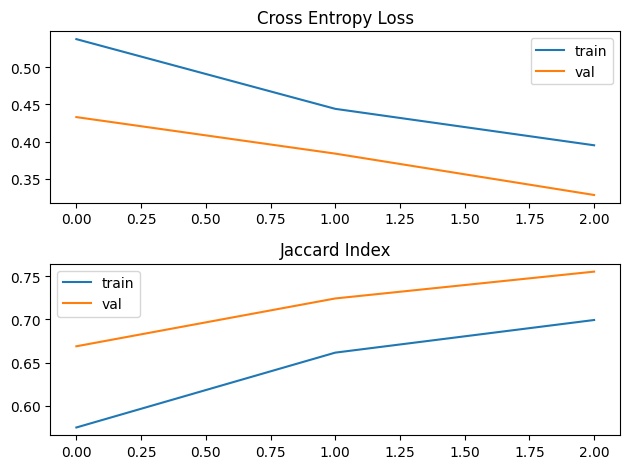

In [14]:
plotTrainingHistory(train_history, val_history)

## Test the model

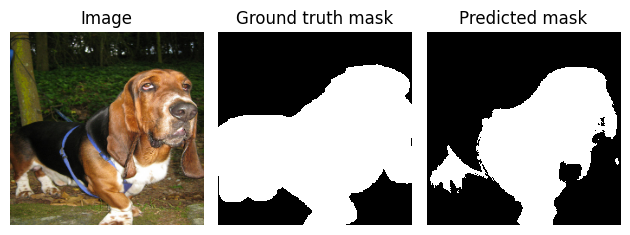

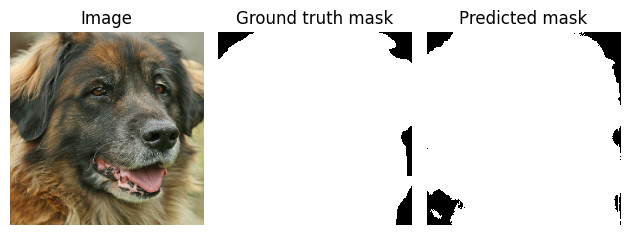

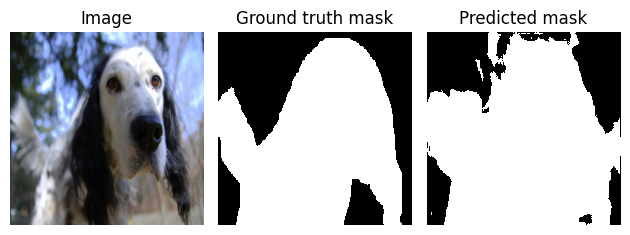

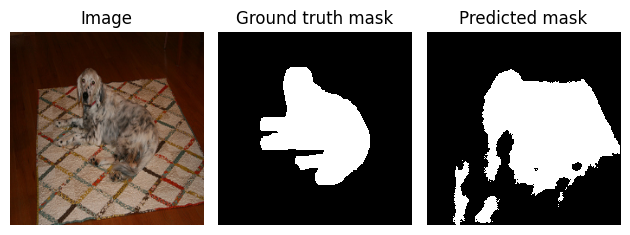

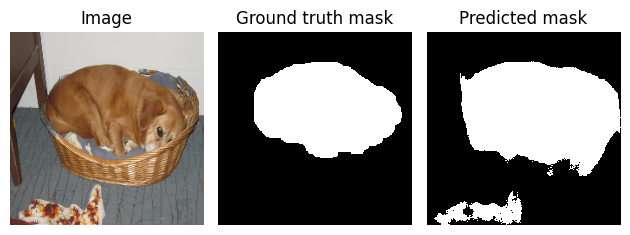

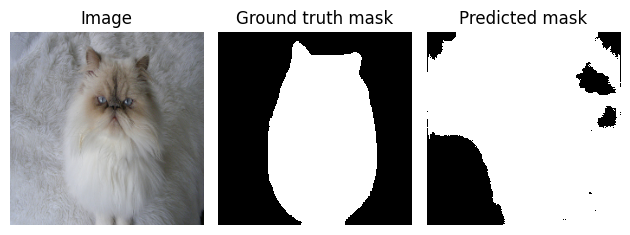

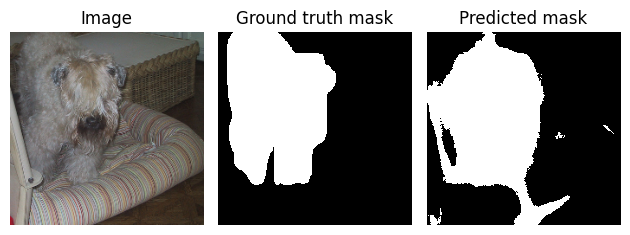

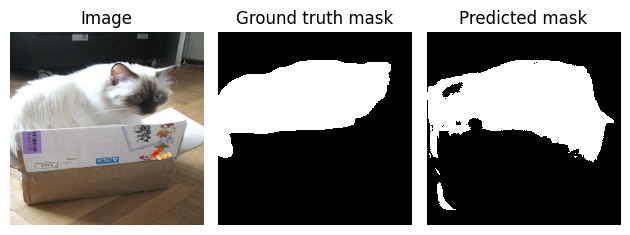

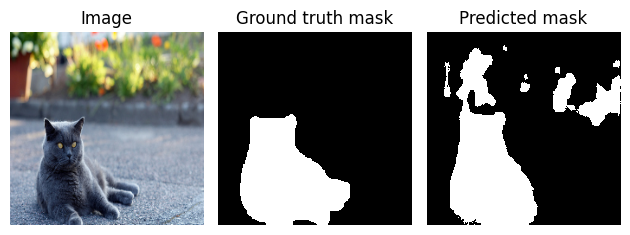

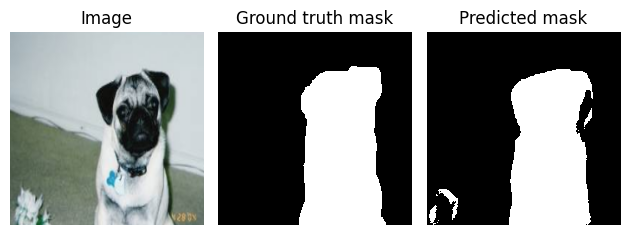

In [15]:
# test the model on some images from the validation dataset
# compare the predicted with the ground-truth masks

# load the best model
model = SegmentationNetwork(n_channels=3, n_classes=nr_classes).to(device)
checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model'])
model.eval()

inference_transform = A.Compose(
    [A.Resize(256, 256), A.CenterCrop(224, 224), ToTensorV2()]
)
inference_dataset = OxfordPetDataset(val_images_filenames[:10], images_directory, masks_directory, transform=inference_transform,)
inference_dataloader = DataLoader(inference_dataset, batch_size=1, num_workers=num_workers, shuffle=False)

with torch.no_grad():
  for img, mask in inference_dataloader:
      img, mask = img.to(device), mask.to(device)
      out = model(img)
      probs = F.softmax(out, dim=1)
      pred = torch.argmax(probs, dim=1)
      
      fig, ax = plt.subplots(ncols=3)
      ax[0].imshow(img[0].cpu().numpy().transpose((1, 2, 0)))
      ax[1].imshow(mask[0].cpu().numpy(), interpolation="nearest", cmap='gray')
      ax[2].imshow(pred[0].cpu().numpy(), interpolation="nearest", cmap='gray')

      ax[0].set_title("Image")
      ax[1].set_title("Ground truth mask")
      ax[2].set_title("Predicted mask")

      ax[0].set_axis_off()
      ax[1].set_axis_off()
      ax[2].set_axis_off()

      plt.tight_layout()
      plt.show()


## Challenge
Add the Dice loss to the training of the network and compare the results.

